In [1]:
#17011d57142c4a08089d7a61548de4f7cd9bb98bb186872eea1889a03c47ca73

In [18]:
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
import mlflow
import os

In [4]:
#mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("ARIMAmodel")

In [5]:

def fetch_historical_data(api_key, limit=2000):
    url = f"https://min-api.cryptocompare.com/data/v2/histohour"
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': limit,
        'api_key': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()['Data']['Data']
    return pd.DataFrame(data)

api_key = '17011d57142c4a08089d7a61548de4f7cd9bb98bb186872eea1889a03c47ca73'
df = fetch_historical_data(api_key)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              2001 non-null   int64  
 1   high              2001 non-null   float64
 2   low               2001 non-null   float64
 3   open              2001 non-null   float64
 4   volumefrom        2001 non-null   float64
 5   volumeto          2001 non-null   float64
 6   close             2001 non-null   float64
 7   conversionType    2001 non-null   object 
 8   conversionSymbol  2001 non-null   object 
dtypes: float64(6), int64(1), object(2)
memory usage: 140.8+ KB


In [7]:
## there's no  missing values
#df.isnull().sum()

In [8]:
df = df.drop(columns=['conversionType', 'conversionSymbol'])


In [9]:
# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'], unit='s')

# Set time as index
df.set_index('time', inplace=True)

In [10]:
# Define the split ratio
train_size = int(len(df) * 0.8)

# Split the data
train, test = df[:train_size], df[train_size:]


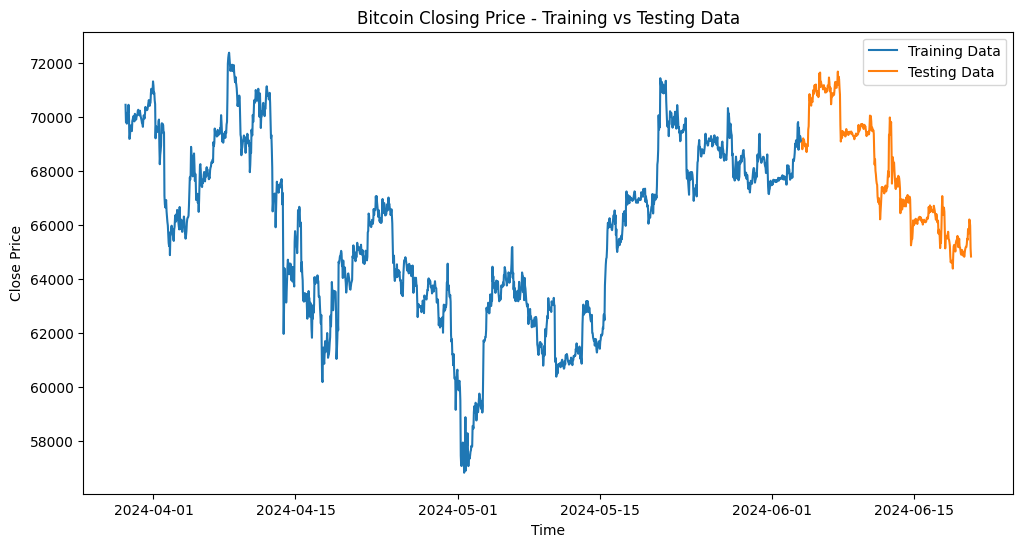

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(train['close'], label='Training Data')
plt.plot(test['close'], label='Testing Data')
plt.title('Bitcoin Closing Price - Training vs Testing Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [12]:
# Perform Augmented Dickey-Fuller test
result = adfuller(df['close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#If the p-value is greater than 0.05, the time series is not stationary and we might need to difference the data.

ADF Statistic: -2.5659596134534115
p-value: 0.10023877302971157


In [13]:
# If p-value > 0.05, apply differencing
if result[1] > 0.05:
    df['close_diff'] = df['close'].diff().dropna()

    # Perform ADF test on differenced data
    result_diff = adfuller(df['close_diff'].dropna())
    print(f'ADF Statistic (Differenced): {result_diff[0]}')
    print(f'p-value (Differenced): {result_diff[1]}')

    if result_diff[1] < 0.05:
        print("Data is stationary after differencing.")
        d = 1
    else:
        print("Further differencing needed.")
else:
    print("Data is already stationary.")
    d = 0

ADF Statistic (Differenced): -44.7323056440304
p-value (Differenced): 0.0
Data is stationary after differencing.


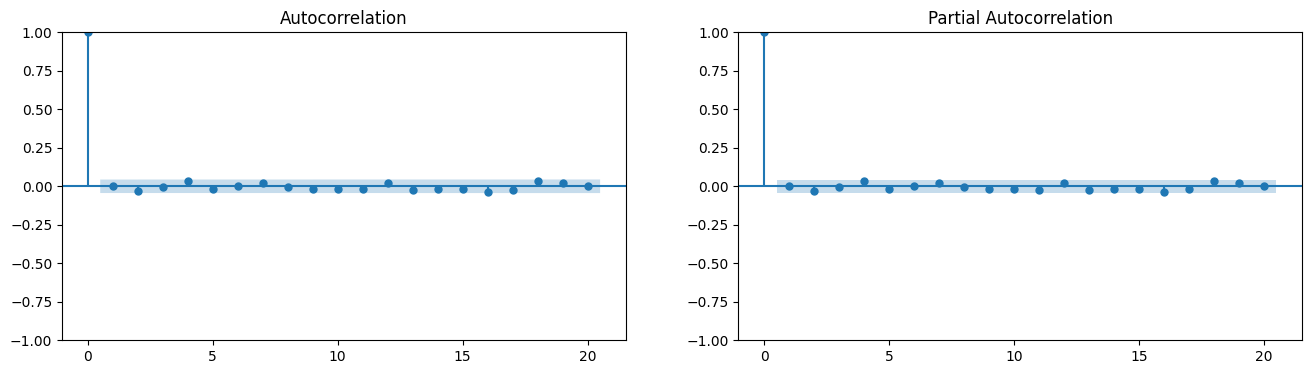

In [14]:
# ACF and PACF plots for differenced data if differencing was applied
if d == 1:
    series_to_use = df['close_diff'].dropna()
else:
    series_to_use = df['close']

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sm.graphics.tsa.plot_acf(series_to_use, lags=20, ax=axes[0])
sm.graphics.tsa.plot_pacf(series_to_use, lags=20, ax=axes[1])
plt.show()

In [15]:
# Based on the plots and differencing
p = 1
q = 1

# Fit ARIMA model
model = ARIMA(df['close'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\drago\Documents\Ironhack\Week8\lydia_mlops\venv_mlops\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\drago\Documents\Ironhack\Week8\lydia_mlops\venv_mlops\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\drago\Documents\Ironhack\Week8\lydia_mlops\venv_mlops\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2001
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14506.122
Date:                Thu, 20 Jun 2024   AIC                          29018.244
Time:                        16:48:11   BIC                          29035.046
Sample:                    03-29-2024   HQIC                         29024.413
                         - 06-20-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3890      0.569      0.683      0.494      -0.727       1.505
ma.L1         -0.4089      0.566     -0.722      0.470      -1.518       0.701
sigma2      1.168e+05   1547.518     75.472      0.0

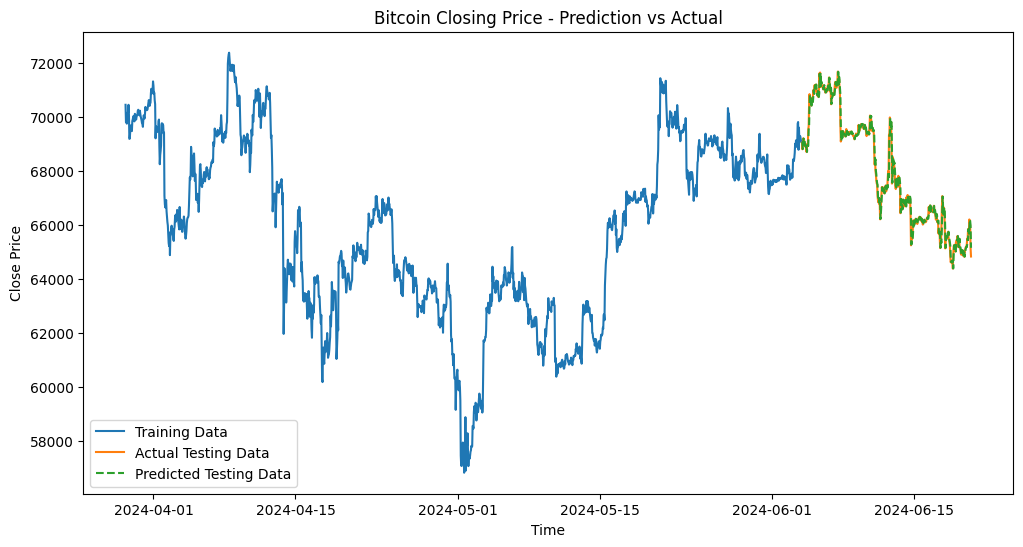

In [16]:
# Predicting the test set
start_index = test.index[0]
end_index = test.index[-1]
predictions = model_fit.predict(start=start_index, end=end_index, typ='levels')

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(train['close'], label='Training Data')
plt.plot(test['close'], label='Actual Testing Data')
plt.plot(predictions, label='Predicted Testing Data', linestyle='--')
plt.title('Bitcoin Closing Price - Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [19]:
import numpy as np
mae = mean_absolute_error(test['close'], predictions)
rmse = np.sqrt(mean_squared_error(test['close'], predictions))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 166.33772681279777
Root Mean Squared Error (RMSE): 257.9504125430774


In [ ]:
## how far is out the mean 252

In [20]:
from sklearn.metrics import r2_score
# Calculate R-squared
r2 = r2_score(test['close'], predictions)
print(f'R² Score: {r2}')

R² Score: 0.9844173739339117
